In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image

import timm

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
# ==========================================
# 1. CONFIGURATION
# ==========================================

# Paths
DATA_ROOT = "/kaggle/input/affectnet"
ORIGINAL_CSV = "/kaggle/input/affectnet/labels.csv"
AUGMENTED_CSV = "/kaggle/input/affectnet/combined_labels.csv" 

# Using saved testset from Baseline Model 
EXTERNAL_TEST_SPLIT_PATH = "/kaggle/input/testset-from-baseline/saved_testset.csv" 

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
LR = 1e-4

In [3]:
# ==========================================
# 2. DATASET CLASS
# ==========================================
class AffectNetDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        
        if 'pth' in self.data.columns:
            self.path_col = 'pth'
        elif 'filepath' in self.data.columns:
            self.path_col = 'filepath'
        else:
            raise ValueError("CSV must contain 'pth' or 'filepath'")

        self.classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.root_dir, row[self.path_col])
        
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            img = Image.new('RGB', (224, 224), (0, 0, 0)) 

        label = self.class_to_idx[row['label']]

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
# ==========================================
# 3. DATA PREPARATION
# ==========================================

def prepare_data():
    print(f"--- PREPARING DATA ---")
    
    def get_standard_id(path_str):
        return os.path.join(os.path.basename(os.path.dirname(path_str)), os.path.basename(path_str))

    # 1. Load Combined Data
    df_augmented = pd.read_csv(AUGMENTED_CSV)
    if 'filepath' in df_augmented.columns:
        df_augmented['unique_id'] = df_augmented['filepath'].apply(get_standard_id)
        
    print(f"Total samples in augmented dataset (before exclusion): {len(df_augmented)}")
    
    # 2. Load Saved Test IDs
    # Note: No need for explicit "150 samples per class" logic, coz directly using test_ids from Baseline model 
    try:
        df_test_ids = pd.read_csv(EXTERNAL_TEST_SPLIT_PATH)
        test_ids = df_test_ids['unique_id'].values
        print(f"Loaded {len(test_ids)} unique test IDs from saved file.")
    except FileNotFoundError:
        print(f"ERROR: Test split file not found at {EXTERNAL_TEST_SPLIT_PATH}. Upload from baseline model.")
        return None, None, None
    
    # 3. Separate Test Set and Training/Validation Set
    test_df = df_augmented[df_augmented['unique_id'].isin(test_ids)].copy()

    # Remove testset images from training -- prevent leaking
    train_val_df = df_augmented[~df_augmented['unique_id'].isin(test_ids)].copy()
    
    print(f"Samples REMOVED (Final Test Set): {len(test_df)}")
    print(f"Remaining samples for Train/Val: {len(train_val_df)}")
    print(f"Total Check: {len(test_df) + len(train_val_df)} (Should match initial total)")
    
    # 4. Split Train/Val (Stratified)
    # Uses the original 80/20 split ratio (test_size=0.2 means 20% goes to validation)
    print("Splitting Train/Val (Stratified) on remaining data...")
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=0.2,
        random_state=42,
        stratify=train_val_df['label']
    )

    return train_df, val_df, test_df

In [5]:
train_df, val_df, test_df = prepare_data()

--- PREPARING DATA ---
Total samples in augmented dataset (before exclusion): 39112
Loaded 1200 unique test IDs from saved file.
Samples REMOVED (Final Test Set): 1200
Remaining samples for Train/Val: 37912
Total Check: 39112 (Should match initial total)
Splitting Train/Val (Stratified) on remaining data...


In [6]:
# ==========================================
# 4. TRANSFORMS & LOADERS
# ==========================================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = AffectNetDataset(train_df, DATA_ROOT, transform=train_transform)
val_dataset = AffectNetDataset(val_df, DATA_ROOT, transform=eval_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [7]:
# ==========================================
# 5. MODEL SETUP
# ==========================================
model = timm.create_model("vit_base_patch16_224", pretrained=True)

# A. MLP Head
in_features = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.GELU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(train_dataset.classes))
)

# B. Freeze All
for param in model.parameters():
    param.requires_grad = False
    
# C. Unfreeze Head
for param in model.head.parameters():
    param.requires_grad = True

# D. Unfreeze Last 2 Blocks (Standard as per Baseline)
for block in model.blocks[-2:]:
    for param in block.parameters():
        param.requires_grad = True
        
if hasattr(model, 'norm'):
    for param in model.norm.parameters():
        param.requires_grad = True

model.to(DEVICE)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [8]:
def count_parameters(model):
    table = []
    total_params = 0
    trainable_params = 0
    
    print("\n--- TRAINABLE LAYERS ---")
    for name, param in model.named_parameters():
        total_params += param.numel()
        if param.requires_grad:
            table.append(name)
            trainable_params += param.numel()
            
    # Print first few and last few layers
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print("Sample Trainable Layers:")
    for name in table[:3]: print(f"  {name}")
    print("  ...")
    for name in table[-3:]: print(f"  {name}")

count_parameters(model)


--- TRAINABLE LAYERS ---
Total Parameters: 86,197,512
Trainable Parameters: 14,576,136
Sample Trainable Layers:
  blocks.10.norm1.weight
  blocks.10.norm1.bias
  blocks.10.attn.qkv.weight
  ...
  head.1.bias
  head.4.weight
  head.4.bias


In [9]:
# ==========================================
# 6. TRAINING LOOP
# ==========================================

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

MAX_EPOCHS = 30
PATIENCE = 5
best_acc = 0.0
trigger_times = 0
save_path = "/kaggle/working/vit_augmented_best_model.pth"

# 1. Initialize History Lists
train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

print(f"\nTraining Started... (Classes: {train_dataset.classes})")

for epoch in range(MAX_EPOCHS):
    
    # --- TRAINING ---
    model.train()
    running_train_loss = 0
    train_correct = 0
    train_total = 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        
        # Calculate Train Accuracy
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        
    avg_train_loss = running_train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total
    
    # --- VALIDATION ---
    model.eval()
    running_val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            
            # Calculate Validation Loss
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            
    avg_val_loss = running_val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    
    scheduler.step()

    # 2. Append Metrics to History
    train_loss_hist.append(avg_train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(avg_val_loss)
    val_acc_hist.append(val_acc)
    
    # 3. Enhanced Logging
    print(f"\nEpoch [{epoch+1}/{MAX_EPOCHS}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Train Acc:  {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    
    # --- CHECKPOINT & EARLY STOPPING ---
    if val_acc > best_acc:
        print(f"--> Improvement! Saving Model...")
        best_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), save_path)
    else:
        trigger_times += 1
        if trigger_times >= PATIENCE:
            print(f"Stopping Early.")
            break

print(f"\nFinal Best Validation Accuracy: {best_acc:.2f}%")
print(f"Best model saved at: {save_path}")


Training Started... (Classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

Epoch [1/30]
Train Loss: 1.4414 | Val Loss: 1.3187
Train Acc:  52.69% | Val Acc: 58.39%
--> Improvement! Saving Model...

Epoch [2/30]
Train Loss: 1.2628 | Val Loss: 1.2358
Train Acc:  61.62% | Val Acc: 62.28%
--> Improvement! Saving Model...

Epoch [3/30]
Train Loss: 1.1748 | Val Loss: 1.2186
Train Acc:  66.09% | Val Acc: 63.34%
--> Improvement! Saving Model...

Epoch [4/30]
Train Loss: 1.0974 | Val Loss: 1.2077
Train Acc:  69.92% | Val Acc: 64.41%
--> Improvement! Saving Model...

Epoch [5/30]
Train Loss: 1.0155 | Val Loss: 1.2207
Train Acc:  74.17% | Val Acc: 64.57%
--> Improvement! Saving Model...

Epoch [6/30]
Train Loss: 0.9278 | Val Loss: 1.2372
Train Acc:  78.92% | Val Acc: 64.62%
--> Improvement! Saving Model...

Epoch [7/30]
Train Loss: 0.8376 | Val Loss: 1.2866
Train Acc:  83.16% | Val Acc: 64.22%

Epoch [8/30]
Train Loss: 0.7518 | Val Loss: 1.3114
Train Acc:  87.


Generating Plots...


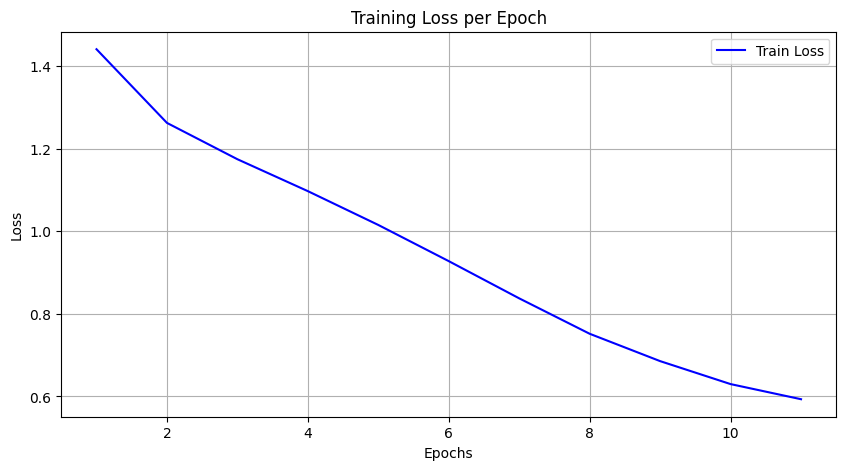

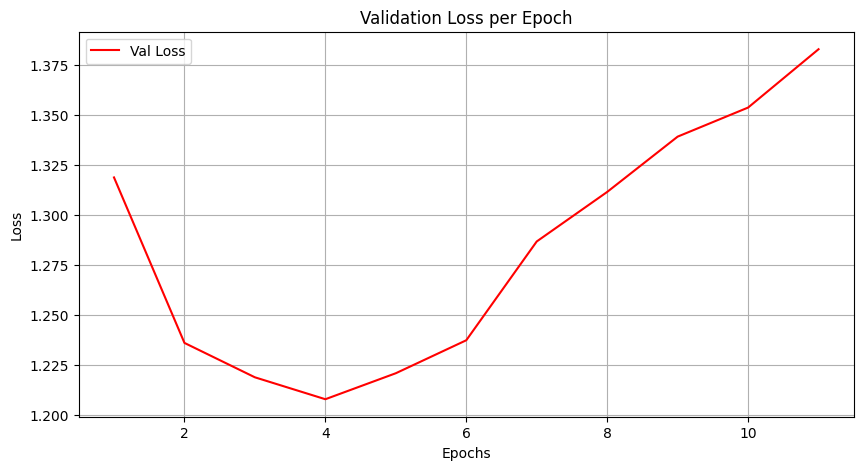

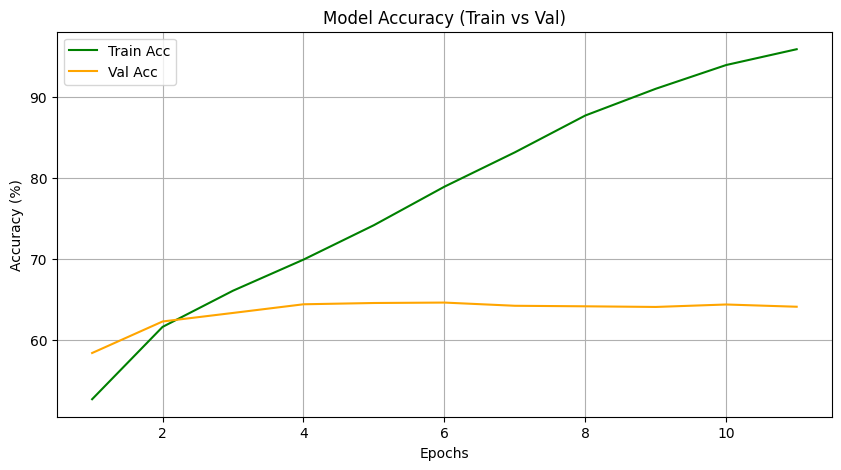

In [10]:
# ==========================================
# 7. PLOTTING
# ==========================================
print("\nGenerating Plots...")

actual_epochs = range(1, len(train_loss_hist) + 1)

# Plot 1: Training Loss
plt.figure(figsize=(10, 5))
plt.plot(actual_epochs, train_loss_hist, label='Train Loss', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("/kaggle/working", "training_loss_plot.png"))
plt.show()

# Plot 2: Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(actual_epochs, val_loss_hist, label='Val Loss', color='red')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("/kaggle/working", "val_loss_plot.png"))
plt.show()

# Plot 3: Accuracy (Train vs Val)
plt.figure(figsize=(10, 5))
plt.plot(actual_epochs, train_acc_hist, label='Train Acc', color='green')
plt.plot(actual_epochs, val_acc_hist, label='Val Acc', color='orange')
plt.title('Model Accuracy (Train vs Val)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("/kaggle/working", "accuracy_plot.png"))
plt.show()


FINAL TEST EVALUATION (Unseen Data)
Loading best model from: /kaggle/working/vit_augmented_best_model.pth
Evaluating on 1200 unseen test images...
Saving sample images to: /kaggle/working/Inference_Results

>>> FINAL TEST ACCURACY: 64.67% <<<
---------------------------------------------
Class        | Accuracy   | Samples
---------------------------------------------
anger        |  58.00%    | 150
contempt     |  59.33%    | 150
disgust      |  55.33%    | 150
fear         |  66.67%    | 150
happy        |  94.00%    | 150
neutral      |  55.33%    | 150
sad          |  58.00%    | 150
surprise     |  70.67%    | 150
---------------------------------------------

Generating Confusion Matrix...


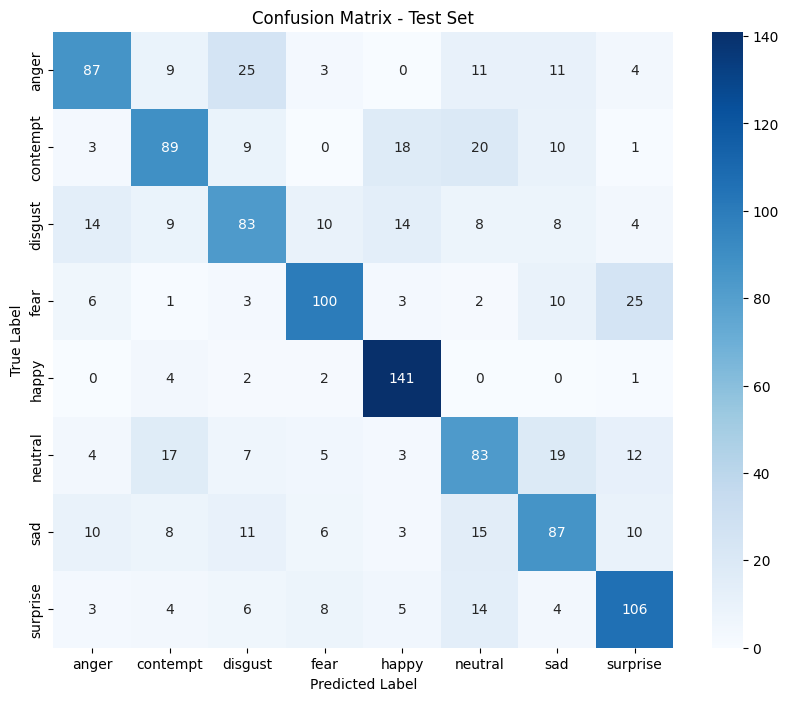


Classification Report:
              precision    recall  f1-score   support

       anger       0.69      0.58      0.63       150
    contempt       0.63      0.59      0.61       150
     disgust       0.57      0.55      0.56       150
        fear       0.75      0.67      0.70       150
       happy       0.75      0.94      0.84       150
     neutral       0.54      0.55      0.55       150
         sad       0.58      0.58      0.58       150
    surprise       0.65      0.71      0.68       150

    accuracy                           0.65      1200
   macro avg       0.65      0.65      0.64      1200
weighted avg       0.65      0.65      0.64      1200



In [11]:
# ==========================================
# 8. FINAL TEST EVALUATION (Unseen Data)
# ==========================================
print("\n" + "="*40)
print("FINAL TEST EVALUATION (Unseen Data)")
print("="*40)

# --- 1. SETUP OUTPUT DIRECTORIES ---
OUTPUT_DIR = "/kaggle/working/Inference_Results"
CORRECT_DIR = os.path.join(OUTPUT_DIR, "Correct")
INCORRECT_DIR = os.path.join(OUTPUT_DIR, "Incorrect")

os.makedirs(CORRECT_DIR, exist_ok=True)
os.makedirs(INCORRECT_DIR, exist_ok=True)

# Function to un-normalize image for saving (assuming mean=0.5, std=0.5)
def unnormalize(tensor):
    return tensor * 0.5 + 0.5

# --- 2. LOADERS AND MODEL ---
# Instantiate Test Loader
# Note: Using test_df and eval_transform from previous sections
test_dataset = AffectNetDataset(test_df, DATA_ROOT, transform=eval_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Load Best Model
checkpoint_path = "/kaggle/working/vit_augmented_best_model.pth"


if os.path.exists(checkpoint_path):
    print(f"Loading best model from: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
else:
    print(f"Warning: Checkpoint not found at {checkpoint_path}. Using current model state.")

model.eval()

# Metrics Containers
correct = 0
total = 0
all_preds = []
all_targets = []

# Class-wise stats containers
num_classes = len(test_dataset.classes)
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# Limits to prevent saving too many files
MAX_SAVE = 250
saved_count = 0

print(f"Evaluating on {len(test_dataset)} unseen test images...")
print(f"Saving sample images to: {OUTPUT_DIR}")

with torch.no_grad():
    for batch_idx, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        # Update lists for Confusion Matrix
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

        # Update Overall Accuracy stats
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # --- PER-CLASS STATS LOGIC ---
        c = (preds == labels).squeeze()
        # Handle case if batch size is 1 or squeeze reduces dimensions too much
        if c.ndim == 0:
             c = c.unsqueeze(0)

        for i in range(len(labels)):
            label = labels[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1

        # --- SAVE IMAGES LOGIC ---
        if saved_count < MAX_SAVE:
            for i in range(len(labels)):
                if saved_count >= MAX_SAVE:
                    break

                # Get single image, label, and prediction
                img_tensor = unnormalize(imgs[i]) # Undo normalization
                true_label = test_dataset.classes[labels[i].item()]
                pred_label = test_dataset.classes[preds[i].item()]

                # Construct filename: Batch_Index_True_vs_Pred.jpg
                filename = f"B{batch_idx}_ID{i}_True_{true_label}_Pred_{pred_label}.jpg"

                if preds[i] == labels[i]:
                    save_path = os.path.join(CORRECT_DIR, filename)
                else:
                    save_path = os.path.join(INCORRECT_DIR, filename)
                
                # Check if it's a tensor on GPU, move to CPU before saving
                save_image(img_tensor.cpu(), save_path)
                saved_count += 1

# --- 3. PRINT ACCURACY ---
final_acc = 100 * correct / total
print(f"\n>>> FINAL TEST ACCURACY: {final_acc:.2f}% <<<")

# --- 4. PRINT PER-CLASS TABLE ---
print("-" * 45)
print(f"{'Class':<12} | {'Accuracy':<10} | {'Samples'}")
print("-" * 45)
for i in range(num_classes):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"{test_dataset.classes[i]:<12} | {acc:>6.2f}%    | {int(class_total[i])}")
    else:
        print(f"{test_dataset.classes[i]:<12} | {'N/A':>6}     | 0")
print("-" * 45)

# --- 5. CONFUSION MATRIX ---
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(all_targets, all_preds)
class_names = test_dataset.classes

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Test Set')
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"))
plt.show()

# --- 6. CLASSIFICATION REPORT (Precision/Recall/F1) ---
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names))

In [12]:
!zip -r /kaggle/working/Inference_Results.zip /kaggle/working/Inference_Results

  adding: kaggle/working/Inference_Results/ (stored 0%)
  adding: kaggle/working/Inference_Results/confusion_matrix.png (deflated 13%)
  adding: kaggle/working/Inference_Results/Incorrect/ (stored 0%)
  adding: kaggle/working/Inference_Results/Incorrect/B1_ID3_True_neutral_Pred_happy.jpg (deflated 2%)
  adding: kaggle/working/Inference_Results/Incorrect/B0_ID4_True_anger_Pred_disgust.jpg (deflated 2%)
  adding: kaggle/working/Inference_Results/Incorrect/B3_ID3_True_anger_Pred_contempt.jpg (deflated 2%)
  adding: kaggle/working/Inference_Results/Incorrect/B6_ID22_True_anger_Pred_fear.jpg (deflated 1%)
  adding: kaggle/working/Inference_Results/Incorrect/B6_ID13_True_surprise_Pred_fear.jpg (deflated 2%)
  adding: kaggle/working/Inference_Results/Incorrect/B6_ID12_True_neutral_Pred_anger.jpg (deflated 2%)
  adding: kaggle/working/Inference_Results/Incorrect/B3_ID4_True_fear_Pred_anger.jpg (deflated 2%)
  adding: kaggle/working/Inference_Results/Incorrect/B3_ID7_True_happy_Pred_contempt.jp